# Przewidywanie trzęsień księżyca - analiza krok po kroku
W tym notatniku przeprowadzimy analizę danych sejsmicznych z Księżyca w celu zbudowania modelu, który będzie przewidywał wystąpienie trzęsienia księżyca w określonym horyzoncie czasowym. Będziemy krok po kroku przetwarzać dane, ekstraktować cechy, budować model i oceniać jego wydajność.


In [1]:
import pandas as pd
import numpy as np
from scipy import signal, stats
from datetime import timedelta
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import joblib
from obspy.signal.trigger import classic_sta_lta


### Definicja funkcji pomocniczych

#### Funkcja do ekstrakcji zaawansowanych cech


In [2]:
def extract_features(velocity_window, sampling_rate):
    # Cechy w dziedzinie czasu
    mean = np.mean(velocity_window)
    std = np.std(velocity_window)
    max_val = np.max(velocity_window)
    min_val = np.min(velocity_window)
    ptp = np.ptp(velocity_window)
    rms = np.sqrt(np.mean(np.square(velocity_window)))
    skewness = stats.skew(velocity_window)
    kurtosis = stats.kurtosis(velocity_window)
    zero_crossing_rate = ((velocity_window[:-1] * velocity_window[1:]) < 0).sum() / len(velocity_window)
    
    # Cechy w dziedzinie częstotliwości
    nperseg = min(256, len(velocity_window))
    freqs, psd = signal.welch(velocity_window, fs=sampling_rate, nperseg=nperseg)
    dominant_freq = freqs[np.argmax(psd)]
    spectral_centroid = np.sum(freqs * psd) / np.sum(psd)
    spectral_entropy = -np.sum(psd * np.log(psd + 1e-12)) / np.log(len(psd))
    
    # Cechy nieliniowe
    # Możesz dodać entropię aproksymacyjną itp.
    
    # Cechy z algorytmu STA/LTA
    # Ustawienie parametrów STA i LTA
    sta_window = int(1 * sampling_rate)   # 1 sekunda
    lta_window = int(10 * sampling_rate)  # 10 sekund
    if len(velocity_window) >= lta_window:
        cft = classic_sta_lta(velocity_window, sta_window, lta_window)
        # Ponieważ cft ma długość len(velocity_window) - lta_window + 1, bierzemy średnią
        sta_lta_mean = np.mean(cft)
        sta_lta_max = np.max(cft)
        sta_lta_min = np.min(cft)
    else:
        sta_lta_mean = np.nan
        sta_lta_max = np.nan
        sta_lta_min = np.nan
    
    features = {
        'mean': mean,
        'std': std,
        'max': max_val,
        'min': min_val,
        'range': ptp,
        'rms': rms,
        'skewness': skewness,
        'kurtosis': kurtosis,
        'zero_crossing_rate': zero_crossing_rate,
        'dominant_freq': dominant_freq,
        'spectral_centroid': spectral_centroid,
        'spectral_entropy': spectral_entropy,
        'sta_lta_mean': sta_lta_mean,
        'sta_lta_max': sta_lta_max,
        'sta_lta_min': sta_lta_min,
    }
    return features


<div class="alert alert-block alert-info"> <b>NOTE:</b> Funkcja <code>extract_features</code> służy do ekstrakcji różnych cech z okna sygnału sejsmicznego. Zawiera zarówno cechy w dziedzinie czasu, jak i częstotliwości. </div>

In [3]:
def bandpass_filter(data, sampling_rate, lowcut=0.5, highcut=10.0):
    nyquist = 0.5 * sampling_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    if high >= 1.0:
        high = 0.99
    b, a = signal.butter(4, [low, high], btype='band')
    return signal.filtfilt(b, a, data)


<div class="alert alert-block alert-info"> <b>NOTE:</b> Funkcja <code>bandpass_filter</code> stosuje filtr pasmowo-przepustowy do sygnału w celu usunięcia szumów i wyodrębnienia interesującego nas zakresu częstotliwości. </div>

Funkcja do przetwarzania pojedynczego zdarzenia
python

In [4]:
def process_event(event_data, onset_time, window_size=200, step_size=100, positive_window=600):
    if len(event_data) <= 1:
        return pd.DataFrame(), []
    
    # Upewnij się, że 'time_rel(sec)' jest typu numerycznego
    event_data['time_rel(sec)'] = event_data['time_rel(sec)'].astype(float)
    event_data = event_data.sort_values('time_rel(sec)').reset_index(drop=True)
    
    time_diff = event_data['time_rel(sec)'].iloc[1] - event_data['time_rel(sec)'].iloc[0]
    if time_diff == 0:
        return pd.DataFrame(), []
    sampling_rate = 1 / time_diff

    filtered_velocity = bandpass_filter(event_data['velocity(m/s)'].values, sampling_rate)

    features = []
    labels = []

    for i in range(0, len(event_data) - window_size, step_size):
        window = filtered_velocity[i:i+window_size]
        if len(window) < window_size:
            continue
        window_features = extract_features(window, sampling_rate)
        window_start_time = event_data['time_rel(sec)'].iloc[i]
        time_to_onset = onset_time - window_start_time  # Obie wartości w sekundach

        if time_to_onset >= 0:
            label = 1 if time_to_onset <= positive_window else 0

            features.append(window_features)
            labels.append(label)
    return pd.DataFrame(features), labels


In [5]:
#ekstrakcja danych z pliku 
def extract_relevant_data(file_path, onset_time, start_offset=7200, end_offset=0):
    # Pobieramy dane od (onset_time - start_offset) do (onset_time)
    df = pd.read_csv(file_path, parse_dates=['time_abs(%Y-%m-%dT%H:%M:%S.%f)'])
    # df.rename(columns={'time_abs(%Y-%m-%dT%H:%M:%S.%f)': 'time_abs', 'time_rel(sec)': 'time_rel'}, inplace=True)
    end_time = onset_time - timedelta(seconds=end_offset)
    start_time = onset_time - timedelta(seconds=start_offset)
    return df[(df['time_abs(%Y-%m-%dT%H:%M:%S.%f)'] >= start_time) & 
              (df['time_abs(%Y-%m-%dT%H:%M:%S.%f)'] <= end_time)].copy()


In [6]:
# Ścieżka do katalogu zdarzeń
catalog_path = '../data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv'
catalog = pd.read_csv(catalog_path, parse_dates=['time_abs(%Y-%m-%dT%H:%M:%S.%f)'])
catalog['time_rel(sec)'] = catalog['time_rel(sec)'].astype(float)

# catalog.rename(columns={'time_abs(%Y-%m-%dT%H:%M:%S.%f)': 'time_abs'}, inplace=True)


### Przetwarzanie kolejnych zapisów sejsmicznych

In [7]:
# Ponowne przetwarzanie danych z uwzględnieniem STA/LTA
all_features = []
all_labels = []

for idx, row in catalog.iterrows():
    filename = row['filename']
    evid = row['evid']
    onset_time = row['time_rel(sec)']  # Używamy czasu relatywnego
    csv_file = f'../data/lunar/training/data/S12_GradeA/{filename}.csv'
    
    if os.path.exists(csv_file):
        try:
            # Wczytanie danych sejsmicznych
            event_data = pd.read_csv(csv_file)
            event_data['time_rel(sec)'] = event_data['time_rel(sec)'].astype(float)
            if not event_data.empty:
                # Przetwarzanie zdarzenia
                event_features, event_labels = process_event(event_data, onset_time)
                if not event_features.empty:
                    event_features['evid'] = evid
                    all_features.append(event_features)
                    all_labels.extend(event_labels)
                    print(f"Przetworzono {filename}")
        except Exception as e:
            print(f"Błąd podczas przetwarzania {filename}: {str(e)}")
    else:
        print(f"Plik nie znaleziony: {csv_file}")

# Łączenie wszystkich cech i etykiet
ml_data = pd.concat(all_features, ignore_index=True)
ml_data['label'] = all_labels


Przetworzono xa.s12.00.mhz.1970-01-19HR00_evid00002
Przetworzono xa.s12.00.mhz.1970-03-25HR00_evid00003
Przetworzono xa.s12.00.mhz.1970-03-26HR00_evid00004
Przetworzono xa.s12.00.mhz.1970-04-25HR00_evid00006
Przetworzono xa.s12.00.mhz.1970-04-26HR00_evid00007
Przetworzono xa.s12.00.mhz.1970-06-15HR00_evid00008
Przetworzono xa.s12.00.mhz.1970-06-26HR00_evid00009
Przetworzono xa.s12.00.mhz.1970-07-20HR00_evid00010
Przetworzono xa.s12.00.mhz.1970-07-20HR00_evid00011
Przetworzono xa.s12.00.mhz.1970-09-26HR00_evid00013
Przetworzono xa.s12.00.mhz.1970-10-24HR00_evid00014
Przetworzono xa.s12.00.mhz.1970-11-12HR00_evid00015
Przetworzono xa.s12.00.mhz.1970-12-11HR00_evid00017
Przetworzono xa.s12.00.mhz.1970-12-27HR00_evid00019
Przetworzono xa.s12.00.mhz.1970-12-31HR00_evid00021
Przetworzono xa.s12.00.mhz.1971-01-15HR00_evid00022
Przetworzono xa.s12.00.mhz.1971-01-28HR00_evid00023
Przetworzono xa.s12.00.mhz.1971-01-29HR00_evid00024
Przetworzono xa.s12.00.mhz.1971-02-09HR00_evid00026
Przetworzono

In [8]:
# Łączenie wszystkich cech i etykiet
ml_data = pd.concat(all_features, ignore_index=True)
ml_data['label'] = all_labels


In [9]:
evids = ml_data['evid'].unique()

train_evids, test_evids = train_test_split(evids, test_size=0.2, random_state=42)

train_data = ml_data[ml_data['evid'].isin(train_evids)]
test_data = ml_data[ml_data['evid'].isin(test_evids)]

X_train = train_data.drop(columns=['evid', 'label'])
y_train = train_data['label']
X_test = test_data.drop(columns=['evid', 'label'])
y_test = test_data['label']


In [10]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Trenowanie modelu
pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])

# Ewaluacja modelu

In [11]:
# Predykcja na zbiorze testowym
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Raport klasyfikacji
print("Raport klasyfikacji:")
print(classification_report(y_test, y_pred))


Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     37743
           1       0.00      0.00      0.00       634

    accuracy                           0.98     38377
   macro avg       0.49      0.50      0.50     38377
weighted avg       0.97      0.98      0.98     38377



/home/haz/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/haz/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/haz/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

ROC AUC Score: 0.49


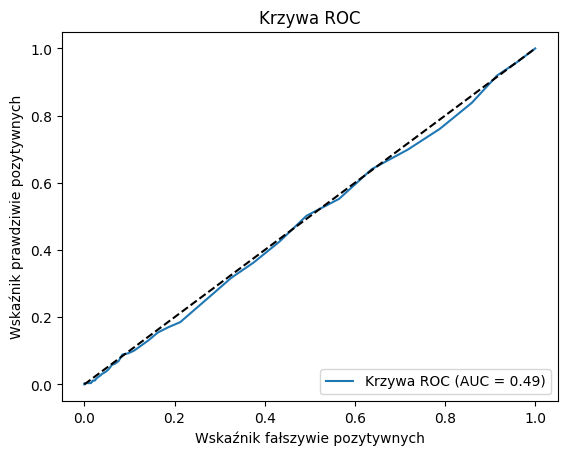

In [20]:
# Obliczanie ROC AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Wykres krzywej ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'Krzywa ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Wskaźnik fałszywie pozytywnych')
plt.ylabel('Wskaźnik prawdziwie pozytywnych')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")
plt.show()


Ranking cech:
1. spectral_centroid (0.1027)
2. kurtosis (0.0993)
3. min (0.0915)
4. skewness (0.0903)
5. max (0.0896)
6. range (0.0895)
7. std (0.0875)
8. rms (0.0867)
9. mean (0.0817)
10. spectral_entropy (0.0812)
11. dominant_freq (0.0511)
12. zero_crossing_rate (0.0488)


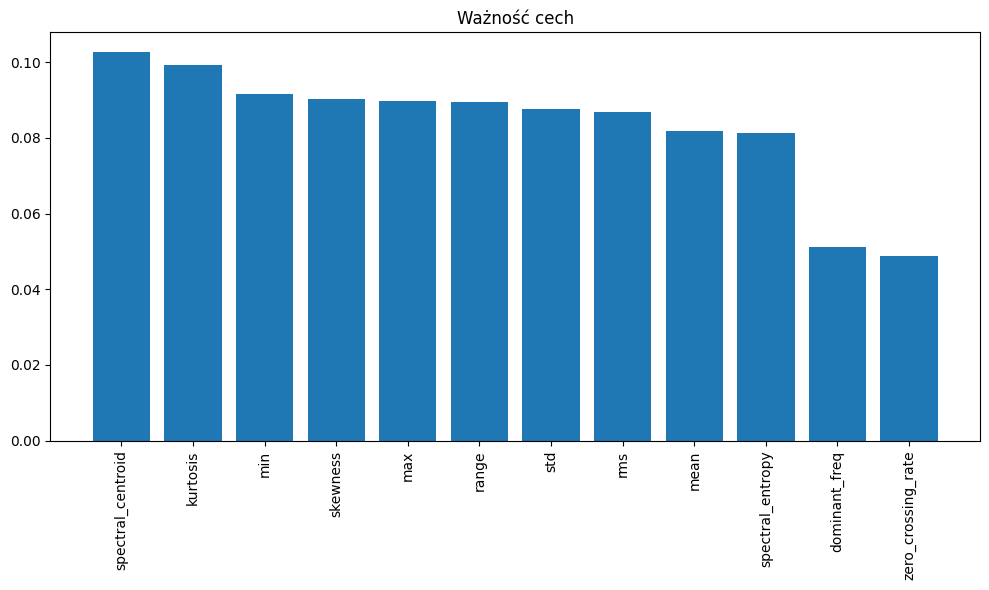

In [21]:
# Ważność cech
importances = pipeline.named_steps['classifier'].feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]

# Wyświetlanie rankingu cech
print("Ranking cech:")
for idx in range(len(feature_names)):
    print(f"{idx + 1}. {feature_names[indices[idx]]} ({importances[indices[idx]]:.4f})")

# Wykres ważności cech
plt.figure(figsize=(10, 6))
plt.title("Ważność cech")
plt.bar(range(len(feature_names)), importances[indices], align="center")
plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()
